In [1]:
import pandas as pd
import seaborn as sns

In [2]:
learning_curves = pd.read_csv('loss.csv', index_col=0, header=[0,1])
learning_curves

training             testing           validation          
          loss     auroc      loss     auroc       loss     auroc
0     4.577466  0.514758  4.560843  0.502457   4.597901  0.483425
1     3.743350  0.487764  3.708273  0.529334   3.738887  0.507361
2     3.386896  0.523409  3.360526  0.491973   3.383525  0.484986
3     3.357265  0.476222  3.326034  0.450313   3.348047  0.533537
4     3.404297  0.487513  3.357603  0.587067   3.388883  0.554489
...        ...       ...       ...       ...        ...       ...
9995  2.719341  0.787346  3.339093  0.549677   3.311158  0.550051
9996  2.860126  0.809436  3.343819  0.502211   3.265197  0.484996
9997  2.814416  0.783909  3.303081  0.508085   3.247702  0.534892
9998  2.783158  0.820934  3.128904  0.537824   3.344523  0.523768
9999  2.843918  0.826980  3.420211  0.533210   3.355490  0.533430

[10000 rows x 6 columns]

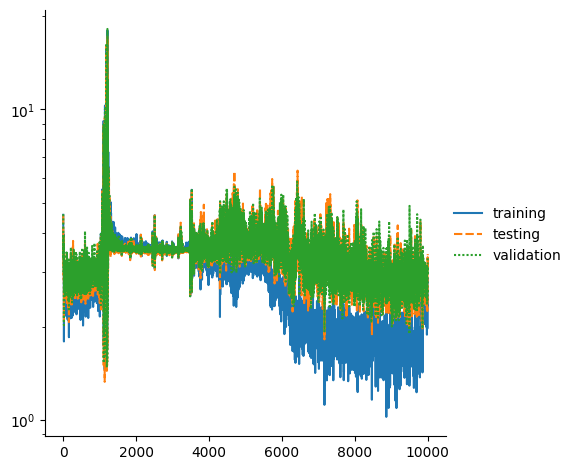

In [3]:
loss_g = sns.relplot(learning_curves.loc[:, (slice(None), 'loss')], kind='line', estimator=None)
loss_g.set(yscale = 'log')
#loss_g.set(xlim = (0, 10000))

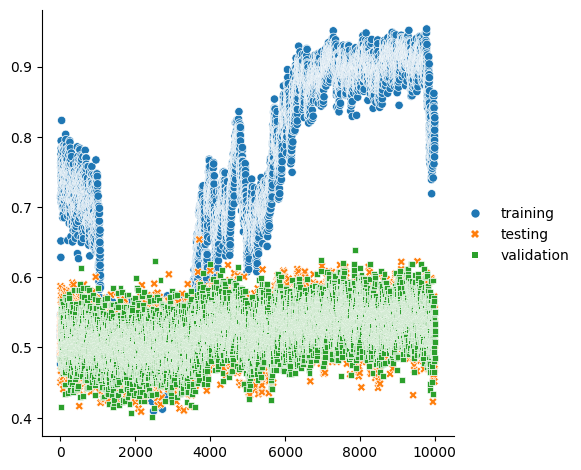

In [4]:
sns.relplot(learning_curves.loc[:, (slice(None), 'auroc')])

In [5]:
import sys
sys.path.append('..')

from train_nnc import NNConvNet
import torch

saved = torch.load('model.pt', map_location=torch.device('cpu'))
saved.keys()

dict_keys(['hyperparameters', 'parameters', 'best_epoch'])

In [6]:
saved['best_epoch']

7865

In [7]:
learning_curves.loc[saved['best_epoch']]

training    loss     1.663669
            auroc    0.901438
testing     loss     3.246021
            auroc    0.559278
validation  loss     2.749764
            auroc    0.638575
Name: 7865, dtype: float64

In [8]:
learning_curves.loc[:, (slice(None), 'auroc')].max(axis='index')

training    auroc    0.953481
testing     auroc    0.653585
validation  auroc    0.638575
dtype: float64

In [9]:
learning_curves.loc[:, (slice(None), 'loss')].min(axis='index')

training    loss    1.023989
testing     loss    1.327590
validation  loss    1.478155
dtype: float64

In [10]:
model = NNConvNet(**saved['hyperparameters'])
model.load_state_dict(saved['parameters'])
model.eval()

NNConvNet(
  (lin_in): Linear(in_features=18949, out_features=10, bias=True)
  (encoder): ModuleList(
    (0-1): 2 x Linear(in_features=10, out_features=10, bias=True)
  )
  (edge_nn): Sequential(
    (0): Linear(in_features=8, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (nnconv): ModuleList()
  (decoder): ModuleList(
    (0-1): 2 x Linear(in_features=10, out_features=10, bias=True)
  )
  (lin_out): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
data = torch.load('../data/cpg0016_v1.pt', map_location=torch.device('cpu'))

In [12]:
with torch.no_grad():
    predict_df = pd.DataFrame({
        'y_hat': torch.softmax(model(data), dim=1)[:, 1],
        'y': data.y[:, 0]
    })
    predict_df['subset'] = 'Neither'
    predict_df['subset'][data.train_mask.numpy()] = 'Training'
    predict_df['subset'][data.test_mask.numpy()] = 'Testing'
    predict_df['subset'][data.val_mask.numpy()] = 'Validation'

/tmp/ipykernel_4058134/2688595686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['subset'][data.train_mask.numpy()] = 'Training'
/tmp/ipykernel_4058134/2688595686.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['subset'][data.test_mask.numpy()] = 'Testing'
/tmp/ipykernel_4058134/2688595686.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['subset'][data.val_mask.numpy()] = 'Validation'


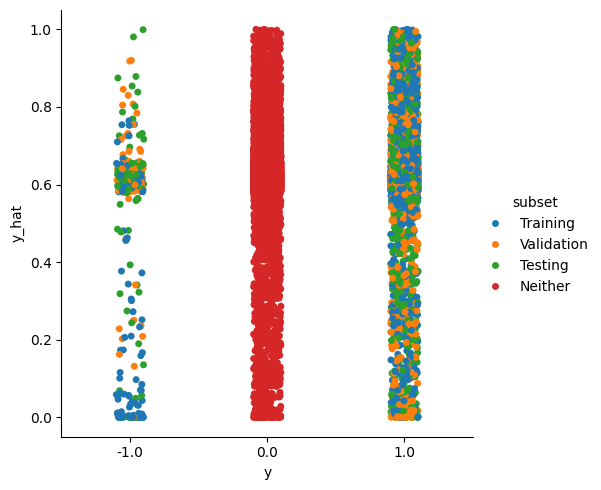

In [13]:
sns.catplot(predict_df, x='y', y='y_hat', hue='subset', kind='strip')

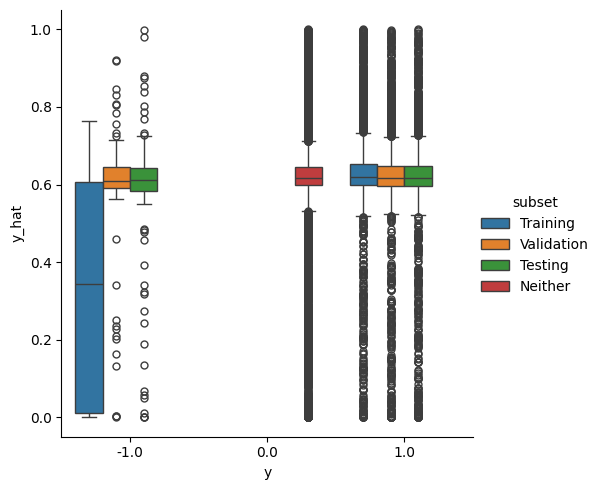

In [14]:
sns.catplot(predict_df, x='y', y='y_hat', hue='subset', kind='box')

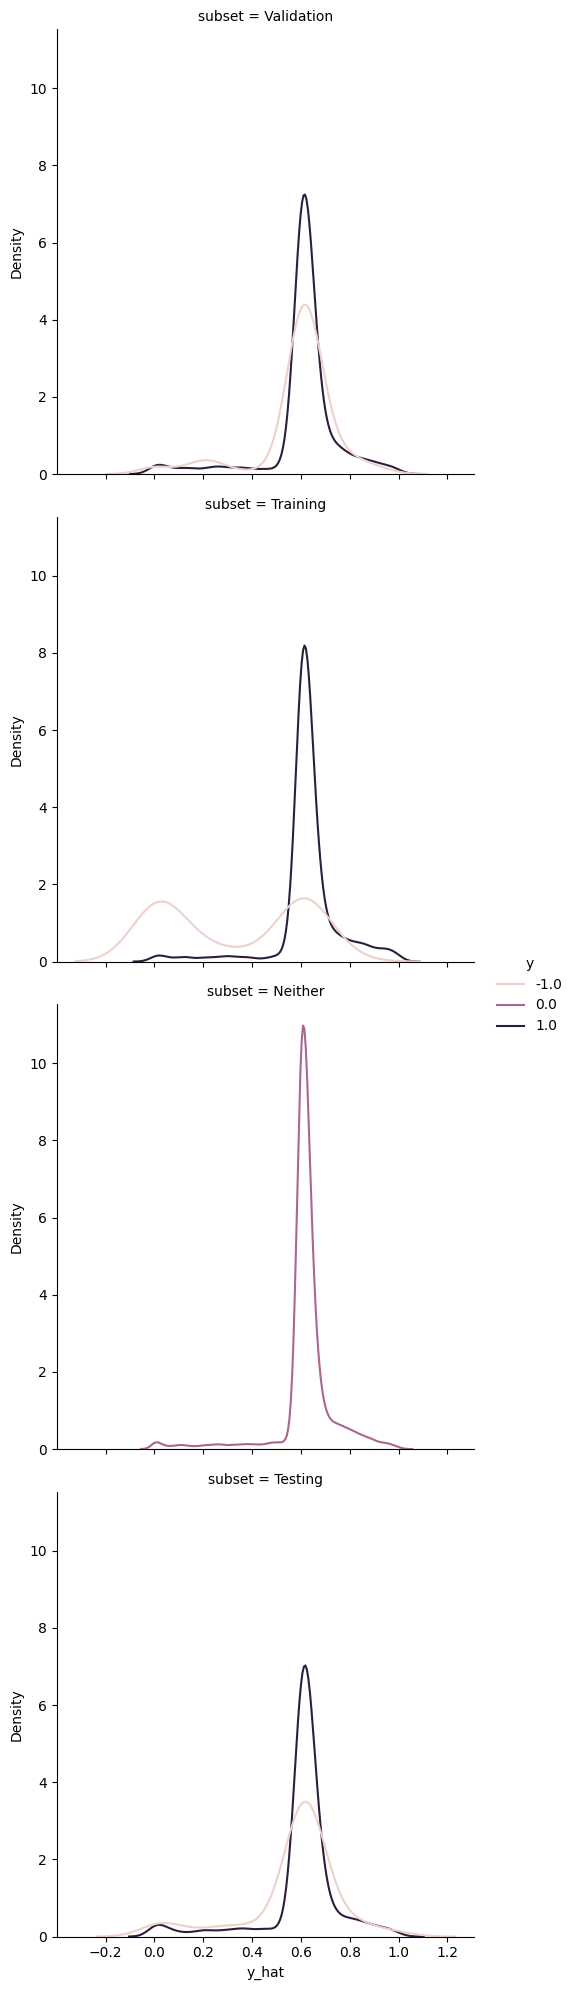

In [15]:
sns.displot(
    predict_df,
    x='y_hat',
    hue='y',
    row='subset',
    kind='kde',
    common_norm=False
)

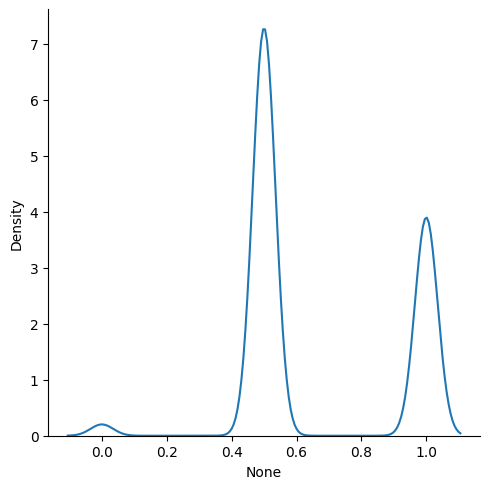

In [16]:
# Verify that data preprocessing isn't screwing this up
y_float = (data.y + 1) * 0.5
sns.displot(x=pd.Series(y_float[:,0].numpy()), kind='kde')

In [17]:
y_int = torch.tensor(y_float, dtype=torch.int64)
pd.Series(y_int[:,0].numpy()).value_counts()

/tmp/ipykernel_4058134/4268706411.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_int = torch.tensor(y_float, dtype=torch.int64)


0    12746
1     6639
Name: count, dtype: int64

In [18]:
for mask in (data.train_mask, data.test_mask, data.val_mask):
    print(pd.Series(y_int[mask,0].numpy()).value_counts())

1    2656
0     137
Name: count, dtype: int64
1    1992
0     104
Name: count, dtype: int64
1    1993
0     103
Name: count, dtype: int64
